# PROJECT: Predicting solar energy generation

## Introduction

In the contemporary global economy, reliable and cost‑effective energy supply constitutes a cornerstone of industrial activity, commercial services, and residential well‑being, yet the inherent variability of both traditional and renewable generation sources poses significant challenges for grid stability and market optimization. Machine learning algorithms offer powerful tools for forecasting energy output by considering inputs such as solar irradiance, ambient temperature, atmospheric humidity, and dynamic shadowing effects; these data‑driven models can capture complex, nonlinear dependencies and patterns. Consequently, the integration of machine learning‑based forecasting into energy management systems not only enhances operational efficiency but also underpins the scalable deployment of renewable technologies, thereby accelerating the transition toward a more sustainable and resilient energy infrastructure.

## Definition of the problem

Predict energy production through supervised learning. This study explores distinct machine learning models which are built and compared to predict energy production based on independent weather variables: wind speed, relative humidity, ambient temperature, and solar irradiation. 

However, for the sake of simplicity, many relevant variables with direct influence to the energy output will not be considered. Those include energy loss through the system (and other electrical implications), solar module efficiency (number of functioning cells, degradation through time), module temperature, etc. 

### Dataset Description

The dataset is obtained from Kaggle: https://www.kaggle.com/datasets/stucom/solar-energy-power-generation-dataset/data

Considering the educational purpose of this project, this dataset was chosen due to its simplicity: the features are easily correlated to energy output. Nevertheless, it is important to highlight the reduced accuracy to real world applications, that involve further analysis and consider more complex calculations, as previously mentioned in the previous paragraph.

Features to be analyzed: 

- Temperature: temperature_2_m_above_gnd

- Humidity: relative_humidity_2_m_above_gnd

- Cloud Cover (total): total_cloud_cover_sfc

              - Cloud Cover (high): high_cloud_cover_high_cld_lay

              - Cloud Cover (medium): medium_cloud_cover_mid_cld_lay

              - Cloud Cover (low): low_cloud_cover_low_cld_lay

- Solar irradiation: shortwave_radiation_backwards_sfc

- Atmospheric Pressure: mean_sea_level_pressure_MSL

- Precipitation: total_precipitation_sfc

- Snowfall: snowfall_amount_sfc

- Wind speed(10m): wind_speed_10_m_above_gnd

- Wind direction(10m): wind_direction_10_m_above_gnd

- Wind speed(80m): wind_speed_80_m_above_gnd

- Wind direction(80m): wind_speed_80_m_above_gnd

- Meteorological measure of wind speed (pressure-related): wind_speed_900_mb

- Meteorological measure of wind direction (pressure-related): wind_direction_900_mb

- Wind Gust (Spikes): wind_gust_10_m_above_gnd

- Angle of Incidence: angle_of_incidence

- Zenith: zenith

- Azimuth: azimuth

- Generated power (kW): generated_power_kw

In [1]:
import pandas as pd
import numpy as np
import itertools as it

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, KBinsDiscretizer
from sklearn.pipeline import Pipeline as SKLPipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import Perceptron, LogisticRegression, LinearRegression, Ridge, Lasso 
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, cross_validate, RepeatedStratifiedKFold
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV, cross_validate


from scipy.stats import loguniform, beta, uniform

import missingno as msno
from mlxtend.feature_selection import SequentialFeatureSelector as SFS 

from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [2]:
df_original = pd.read_csv('spg.csv')

In [3]:
df_original

,temperature_2_m_above_gnd,relative_humidity_2_m_above_gnd,mean_sea_level_pressure_MSL,total_precipitation_sfc,snowfall_amount_sfc,total_cloud_cover_sfc,high_cloud_cover_high_cld_lay,medium_cloud_cover_mid_cld_lay,low_cloud_cover_low_cld_lay,shortwave_radiation_backwards_sfc,...,wind_direction_10_m_above_gnd,wind_speed_80_m_above_gnd,wind_direction_80_m_above_gnd,wind_speed_900_mb,wind_direction_900_mb,wind_gust_10_m_above_gnd,angle_of_incidence,zenith,azimuth,generated_power_kw
0,2.17,31,1035.0,0.0,0.0,0.0,0,0,0,0.00,...,312.71,9.36,22.62,6.62,337.62,24.48,58.753108,83.237322,128.33543,454.100950
1,2.31,27,1035.1,0.0,0.0,0.0,0,0,0,1.78,...,294.78,5.99,32.74,4.61,321.34,21.96,45.408585,75.143041,139.65530,1411.999400
2,3.65,33,1035.4,0.0,0.0,0.0,0,0,0,108.58,...,270.00,3.89,56.31,3.76,286.70,14.04,32.848282,68.820648,152.53769,2214.849300
3,5.82,30,1035.4,0.0,0.0,0.0,0,0,0,258.10,...,323.13,3.55,23.96,3.08,339.44,19.80,22.699288,64.883536,166.90159,2527.609200
4,7.73,27,1034.4,0.0,0.0,0.0,0,0,0,375.58,...,10.01,6.76,25.20,6.62,22.38,16.56,19.199908,63.795208,182.13526,2640.203400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4208,8.69,66,1025.1,0.0,0.0,100.0,100,100,100,257.21,...,285.42,25.50,283.06,24.01,282.99,25.20,22.700907,64.952098,167.06794,173.410560
4209,7.57,90,1026.1,0.0,0.0,100.0,79,100,100,210.04,...,6.91,13.00,4.76,11.61,7.13,10.44,19.307487,63.895118,182.28247,403.792220
4210,7.27,90,1026.3,0.1,0.0,100.0,73,100,100,113.92,...,2.29,8.71,352.87,7.95,354.81,22.32,25.249506,65.827032,197.33868,158.367780
4211,8.25,81,1025.5,0.0,0.0,100.0,74,66,100,186.90,...,11.31,6.29,13.24,5.94,14.04,15.48,36.361161,70.496313,211.30027,126.953060


In [4]:
df_original.shape

(4213, 21)

In [5]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4213 entries, 0 to 4212
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   temperature_2_m_above_gnd          4213 non-null   float64
 1   relative_humidity_2_m_above_gnd    4213 non-null   int64  
 2   mean_sea_level_pressure_MSL        4213 non-null   float64
 3   total_precipitation_sfc            4213 non-null   float64
 4   snowfall_amount_sfc                4213 non-null   float64
 5   total_cloud_cover_sfc              4213 non-null   float64
 6   high_cloud_cover_high_cld_lay      4213 non-null   int64  
 7   medium_cloud_cover_mid_cld_lay     4213 non-null   int64  
 8   low_cloud_cover_low_cld_lay        4213 non-null   int64  
 9   shortwave_radiation_backwards_sfc  4213 non-null   float64
 10  wind_speed_10_m_above_gnd          4213 non-null   float64
 11  wind_direction_10_m_above_gnd      4213 non-null   float

In [6]:
df_original.describe()

,temperature_2_m_above_gnd,relative_humidity_2_m_above_gnd,mean_sea_level_pressure_MSL,total_precipitation_sfc,snowfall_amount_sfc,total_cloud_cover_sfc,high_cloud_cover_high_cld_lay,medium_cloud_cover_mid_cld_lay,low_cloud_cover_low_cld_lay,shortwave_radiation_backwards_sfc,...,wind_direction_10_m_above_gnd,wind_speed_80_m_above_gnd,wind_direction_80_m_above_gnd,wind_speed_900_mb,wind_direction_900_mb,wind_gust_10_m_above_gnd,angle_of_incidence,zenith,azimuth,generated_power_kw
count,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,...,4213.000000,4213.000000,4213.000000,4213.00000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000
mean,15.068111,51.361025,1019.337812,0.031759,0.002808,34.056990,14.458818,20.023499,21.373368,387.759036,...,195.078452,18.978483,191.166862,16.36319,192.447911,20.583489,50.837490,59.980947,169.167651,1134.347313
std,8.853677,23.525864,7.022867,0.170212,0.038015,42.843638,30.711707,36.387948,38.013885,278.459293,...,106.626782,11.999960,108.760021,9.88533,106.516195,12.648899,26.638965,19.857711,64.568385,937.957247
min,-5.350000,7.000000,997.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.540000,0.000000,1.120000,0.00000,1.120000,0.720000,3.755323,17.727761,54.379093,0.000595
25%,8.390000,32.000000,1014.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,142.400000,...,153.190000,10.140000,130.240000,9.18000,148.220000,11.160000,29.408181,45.291631,114.136600,231.700450
50%,14.750000,48.000000,1018.100000,0.000000,0.000000,8.700000,0.000000,0.000000,0.000000,381.810000,...,191.770000,16.240000,187.770000,14.49000,187.990000,18.000000,47.335557,62.142611,163.241650,971.642650
75%,21.290000,70.000000,1023.600000,0.000000,0.000000,100.000000,9.000000,10.000000,10.000000,599.860000,...,292.070000,26.140000,292.040000,21.97000,288.000000,27.000000,69.197492,74.346737,225.085620,2020.966700
max,34.900000,100.000000,1046.800000,3.200000,1.680000,100.000000,100.000000,100.000000,100.000000,952.300000,...,360.000000,66.880000,360.000000,61.11000,360.000000,84.960000,121.635920,128.415370,289.045180,3056.794100


In [7]:
df_original.duplicated().sum()

0

In [8]:
# shows dtypes of each column
df_original.dtypes
     

temperature_2_m_above_gnd            float64
relative_humidity_2_m_above_gnd        int64
mean_sea_level_pressure_MSL          float64
total_precipitation_sfc              float64
snowfall_amount_sfc                  float64
total_cloud_cover_sfc                float64
high_cloud_cover_high_cld_lay          int64
medium_cloud_cover_mid_cld_lay         int64
low_cloud_cover_low_cld_lay            int64
shortwave_radiation_backwards_sfc    float64
wind_speed_10_m_above_gnd            float64
wind_direction_10_m_above_gnd        float64
wind_speed_80_m_above_gnd            float64
wind_direction_80_m_above_gnd        float64
wind_speed_900_mb                    float64
wind_direction_900_mb                float64
wind_gust_10_m_above_gnd             float64
angle_of_incidence                   float64
zenith                               float64
azimuth                              float64
generated_power_kw                   float64
dtype: object

### Feature of the dataset

In [9]:
# Print the name of all the columns 
df_original.columns

Index(['temperature_2_m_above_gnd', 'relative_humidity_2_m_above_gnd',
       'mean_sea_level_pressure_MSL', 'total_precipitation_sfc',
       'snowfall_amount_sfc', 'total_cloud_cover_sfc',
       'high_cloud_cover_high_cld_lay', 'medium_cloud_cover_mid_cld_lay',
       'low_cloud_cover_low_cld_lay', 'shortwave_radiation_backwards_sfc',
       'wind_speed_10_m_above_gnd', 'wind_direction_10_m_above_gnd',
       'wind_speed_80_m_above_gnd', 'wind_direction_80_m_above_gnd',
       'wind_speed_900_mb', 'wind_direction_900_mb',
       'wind_gust_10_m_above_gnd', 'angle_of_incidence', 'zenith', 'azimuth',
       'generated_power_kw'],
      dtype='object')

### Missing Data

First, we visualize missing data by plotting a graph:

<AxesSubplot: >

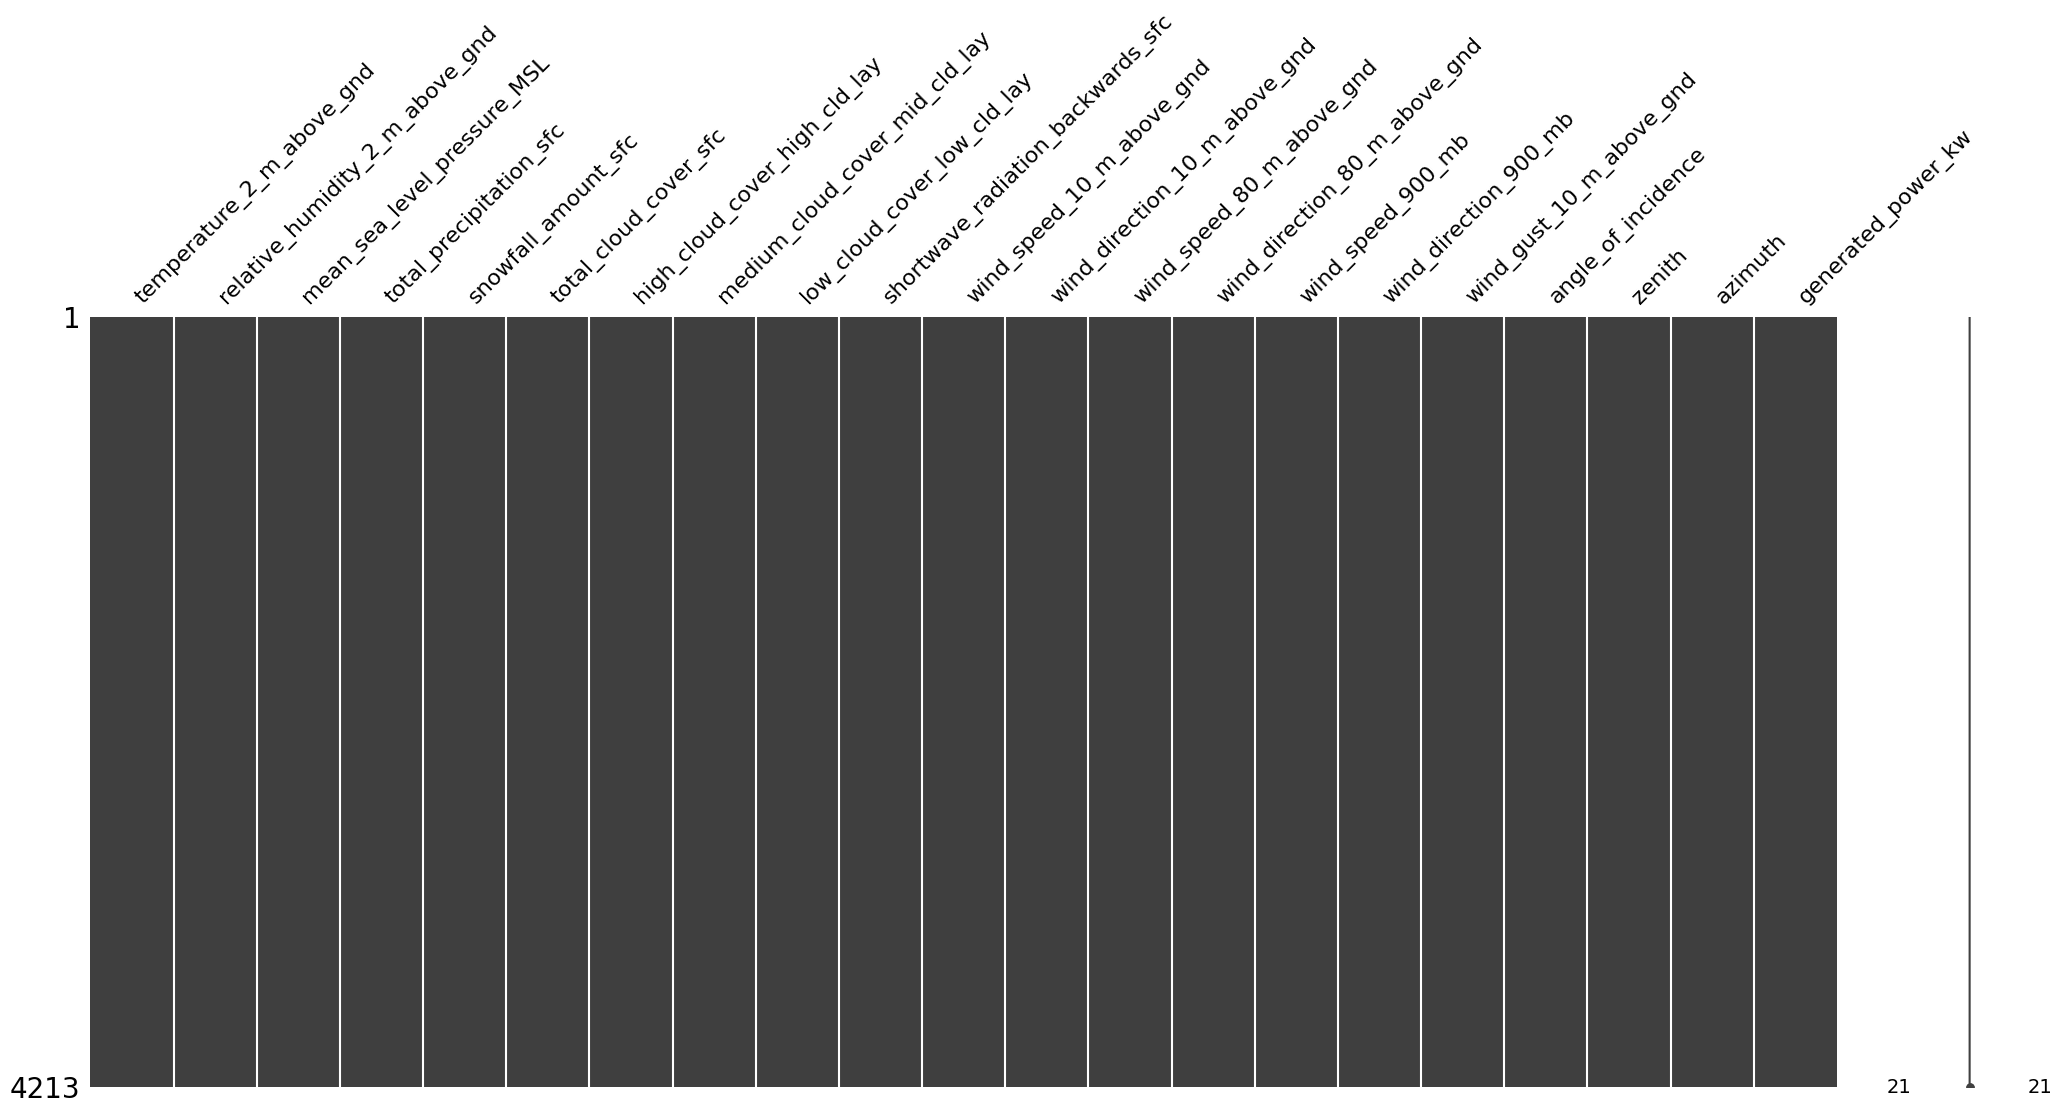

In [10]:
# Show graphycally the missing value
msno.matrix(df_original)

### Introduce missing values

As we have a “perfect” dataset (no missing values) in order to practice missing‑data workflows, we introduce the approach of artificially mask entries according to one of the standard missing‑data mechanisms.

Emulating real‑world complexity: In practice, real datasets often exhibit a mixture of mechanisms (some sensor dropouts are MCAR, some failures are MAR, and some readings fail precisely because the value is extreme → MNAR). To simulate that, you can layer your injection routines: First apply an MCAR mask at rate p₁

Then apply an MAR mask (e.g. conditional on other features) at rate p₂

Then apply an MNAR mask (conditional on its own value) at rate p₃The resulting dataset will contain a realistic blend of missingness patterns.

1) Missing Completely at Random (MCAR): Every cell (or every entry in a given column) has the same probability p of being set to NaN, independent of its value or any other variable.

In [11]:
import numpy as np

# 1) Working copy
X = df_original.copy()   # original full DataFrame
p = 0.1                  # 10% missingness overall

# 2) Build full‐shape mask
mask = np.random.rand(*X.shape) < p

# 3) Exclude the "generated_power_kw" column from being masked
exclude = 'generated_power_kw'
col_idx = X.columns.get_loc(exclude)
mask[:, col_idx] = False

# 4) Apply mask to create missing values
X_missing = X.copy()
X_missing[mask] = np.nan

# 5) Verify
print("Missing in 'generated_power_kw'? ", X_missing['generated_power_kw'].isna().any())  # should be False
print("Overall % missing:", 
      X_missing.isna().sum().sum() / X_missing.size * 100, "%")

# 6) Preview
print("\nFirst few rows with missing values (excluding generated_power_kw):")
print(X_missing.head())



Missing in 'generated_power_kw'?  False
Overall % missing: 9.610841725724233 %

First few rows with missing values (excluding generated_power_kw):
   temperature_2_m_above_gnd  relative_humidity_2_m_above_gnd  \
0                       2.17                             31.0   
1                       2.31                             27.0   
2                       3.65                             33.0   
3                       5.82                             30.0   
4                       7.73                             27.0   

   mean_sea_level_pressure_MSL  total_precipitation_sfc  snowfall_amount_sfc  \
0                       1035.0                      0.0                  0.0   
1                       1035.1                      NaN                  NaN   
2                       1035.4                      0.0                  0.0   
3                       1035.4                      0.0                  0.0   
4                       1034.4                      0.0       

2) Missing at Random (MAR): The chance that a value in column A is missing depends on other columns. For example, high temperatures might lead to more drop‑outs in a humidity sensor:

In [12]:
import pandas as pd
import numpy as np

df = pd.DataFrame({ 'temperature_2_m_above_gnd': np.random.uniform(0, 40, size=4213),
                    'relative_humidity_2_m_above_gnd': np.random.uniform(10, 90, size=4213) })

# Probability of humidity missing increases with temperature
probs = 1 / (1 + np.exp(-0.2*(df['temperature_2_m_above_gnd'] - 25)))   # logistic function centered at 25 °C
mask = np.random.rand(len(df)) < probs
df_original.loc[mask, 'relative_humidity_2_m_above_gnd'] = np.nan


3) Missing Not at Random (MNAR): Whether a value is missing depends on its own (possibly unobserved) value. For instance, very low wind–speed readings might be more likely to fail:

(not applied for now)

In [13]:

#winds = np.random.uniform(0, 15, size=4213)
# If wind < 2 m/s, 30% chance of being missing; otherwise only 5%
#probs = np.where(winds < 2, 0.3, 0.05)
#mask = np.random.rand(len(winds)) < probs
#winds_missing = winds.copy()
#winds_missing[mask] = np.nan


### Stitch “missing‑injected” DataFrame back onto the original

In [14]:
import numpy as np

# 1) Make a polluted copy
df_missing = df_original.copy()

# 2) Set your overall missingness probability
p = 0.1  # 10%

# 3) Build a full‐DataFrame mask and then disable it for the excluded column
mask = np.random.rand(*df_missing.shape) < p
exclude = 'generated_power_kw'
col_idx = df_missing.columns.get_loc(exclude)
mask[:, col_idx] = False   # never mask generated_power_kw

# 4) Apply the mask in one go
df_missing[mask] = np.nan

# 5) Verify
print(f"Missing in '{exclude}':", df_missing[exclude].isna().sum(), "rows")
print("Overall % missing:",
      df_missing.isna().sum().sum() / df_missing.size * 100, "%")


Missing in 'generated_power_kw': 0 rows
Overall % missing: 11.202287703593186 %


### Print and start working with the merged dataset

In [15]:
df_missing

,temperature_2_m_above_gnd,relative_humidity_2_m_above_gnd,mean_sea_level_pressure_MSL,total_precipitation_sfc,snowfall_amount_sfc,total_cloud_cover_sfc,high_cloud_cover_high_cld_lay,medium_cloud_cover_mid_cld_lay,low_cloud_cover_low_cld_lay,shortwave_radiation_backwards_sfc,...,wind_direction_10_m_above_gnd,wind_speed_80_m_above_gnd,wind_direction_80_m_above_gnd,wind_speed_900_mb,wind_direction_900_mb,wind_gust_10_m_above_gnd,angle_of_incidence,zenith,azimuth,generated_power_kw
0,2.17,31.0,1035.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,312.71,9.36,NaN,6.62,337.62,24.48,58.753108,83.237322,128.33543,454.100950
1,2.31,27.0,1035.1,0.0,0.0,0.0,NaN,0.0,0.0,NaN,...,294.78,5.99,NaN,4.61,321.34,21.96,NaN,75.143041,139.65530,1411.999400
2,3.65,NaN,1035.4,0.0,NaN,0.0,0.0,0.0,0.0,108.58,...,NaN,3.89,56.31,3.76,NaN,14.04,NaN,NaN,152.53769,2214.849300
3,5.82,NaN,1035.4,0.0,0.0,0.0,0.0,0.0,NaN,258.10,...,323.13,3.55,NaN,NaN,339.44,19.80,22.699288,64.883536,166.90159,2527.609200
4,7.73,27.0,1034.4,0.0,0.0,0.0,0.0,0.0,0.0,375.58,...,NaN,6.76,NaN,6.62,22.38,16.56,19.199908,NaN,182.13526,2640.203400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4208,8.69,66.0,1025.1,0.0,0.0,100.0,100.0,100.0,100.0,257.21,...,285.42,25.50,283.06,24.01,282.99,25.20,22.700907,64.952098,167.06794,173.410560
4209,NaN,NaN,1026.1,NaN,0.0,100.0,79.0,100.0,100.0,210.04,...,6.91,13.00,4.76,11.61,7.13,10.44,19.307487,63.895118,NaN,403.792220
4210,7.27,NaN,1026.3,0.1,0.0,100.0,73.0,100.0,100.0,113.92,...,2.29,8.71,352.87,7.95,354.81,22.32,25.249506,65.827032,197.33868,158.367780
4211,8.25,NaN,1025.5,0.0,0.0,100.0,74.0,66.0,100.0,186.90,...,NaN,6.29,13.24,5.94,14.04,15.48,36.361161,70.496313,NaN,126.953060


In [16]:
df_missing.shape

(4213, 21)

In [17]:
df_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4213 entries, 0 to 4212
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   temperature_2_m_above_gnd          3831 non-null   float64
 1   relative_humidity_2_m_above_gnd    2340 non-null   float64
 2   mean_sea_level_pressure_MSL        3768 non-null   float64
 3   total_precipitation_sfc            3760 non-null   float64
 4   snowfall_amount_sfc                3791 non-null   float64
 5   total_cloud_cover_sfc              3809 non-null   float64
 6   high_cloud_cover_high_cld_lay      3766 non-null   float64
 7   medium_cloud_cover_mid_cld_lay     3824 non-null   float64
 8   low_cloud_cover_low_cld_lay        3756 non-null   float64
 9   shortwave_radiation_backwards_sfc  3734 non-null   float64
 10  wind_speed_10_m_above_gnd          3812 non-null   float64
 11  wind_direction_10_m_above_gnd      3769 non-null   float

## 

In [18]:
# shows dtypes of each column
df_missing.dtypes

temperature_2_m_above_gnd            float64
relative_humidity_2_m_above_gnd      float64
mean_sea_level_pressure_MSL          float64
total_precipitation_sfc              float64
snowfall_amount_sfc                  float64
total_cloud_cover_sfc                float64
high_cloud_cover_high_cld_lay        float64
medium_cloud_cover_mid_cld_lay       float64
low_cloud_cover_low_cld_lay          float64
shortwave_radiation_backwards_sfc    float64
wind_speed_10_m_above_gnd            float64
wind_direction_10_m_above_gnd        float64
wind_speed_80_m_above_gnd            float64
wind_direction_80_m_above_gnd        float64
wind_speed_900_mb                    float64
wind_direction_900_mb                float64
wind_gust_10_m_above_gnd             float64
angle_of_incidence                   float64
zenith                               float64
azimuth                              float64
generated_power_kw                   float64
dtype: object

### Features of the polluted dataset

In [19]:
# Print the name of all the columns 
df_missing.columns

Index(['temperature_2_m_above_gnd', 'relative_humidity_2_m_above_gnd',
       'mean_sea_level_pressure_MSL', 'total_precipitation_sfc',
       'snowfall_amount_sfc', 'total_cloud_cover_sfc',
       'high_cloud_cover_high_cld_lay', 'medium_cloud_cover_mid_cld_lay',
       'low_cloud_cover_low_cld_lay', 'shortwave_radiation_backwards_sfc',
       'wind_speed_10_m_above_gnd', 'wind_direction_10_m_above_gnd',
       'wind_speed_80_m_above_gnd', 'wind_direction_80_m_above_gnd',
       'wind_speed_900_mb', 'wind_direction_900_mb',
       'wind_gust_10_m_above_gnd', 'angle_of_incidence', 'zenith', 'azimuth',
       'generated_power_kw'],
      dtype='object')

### Show graphically the missing values

<AxesSubplot: >

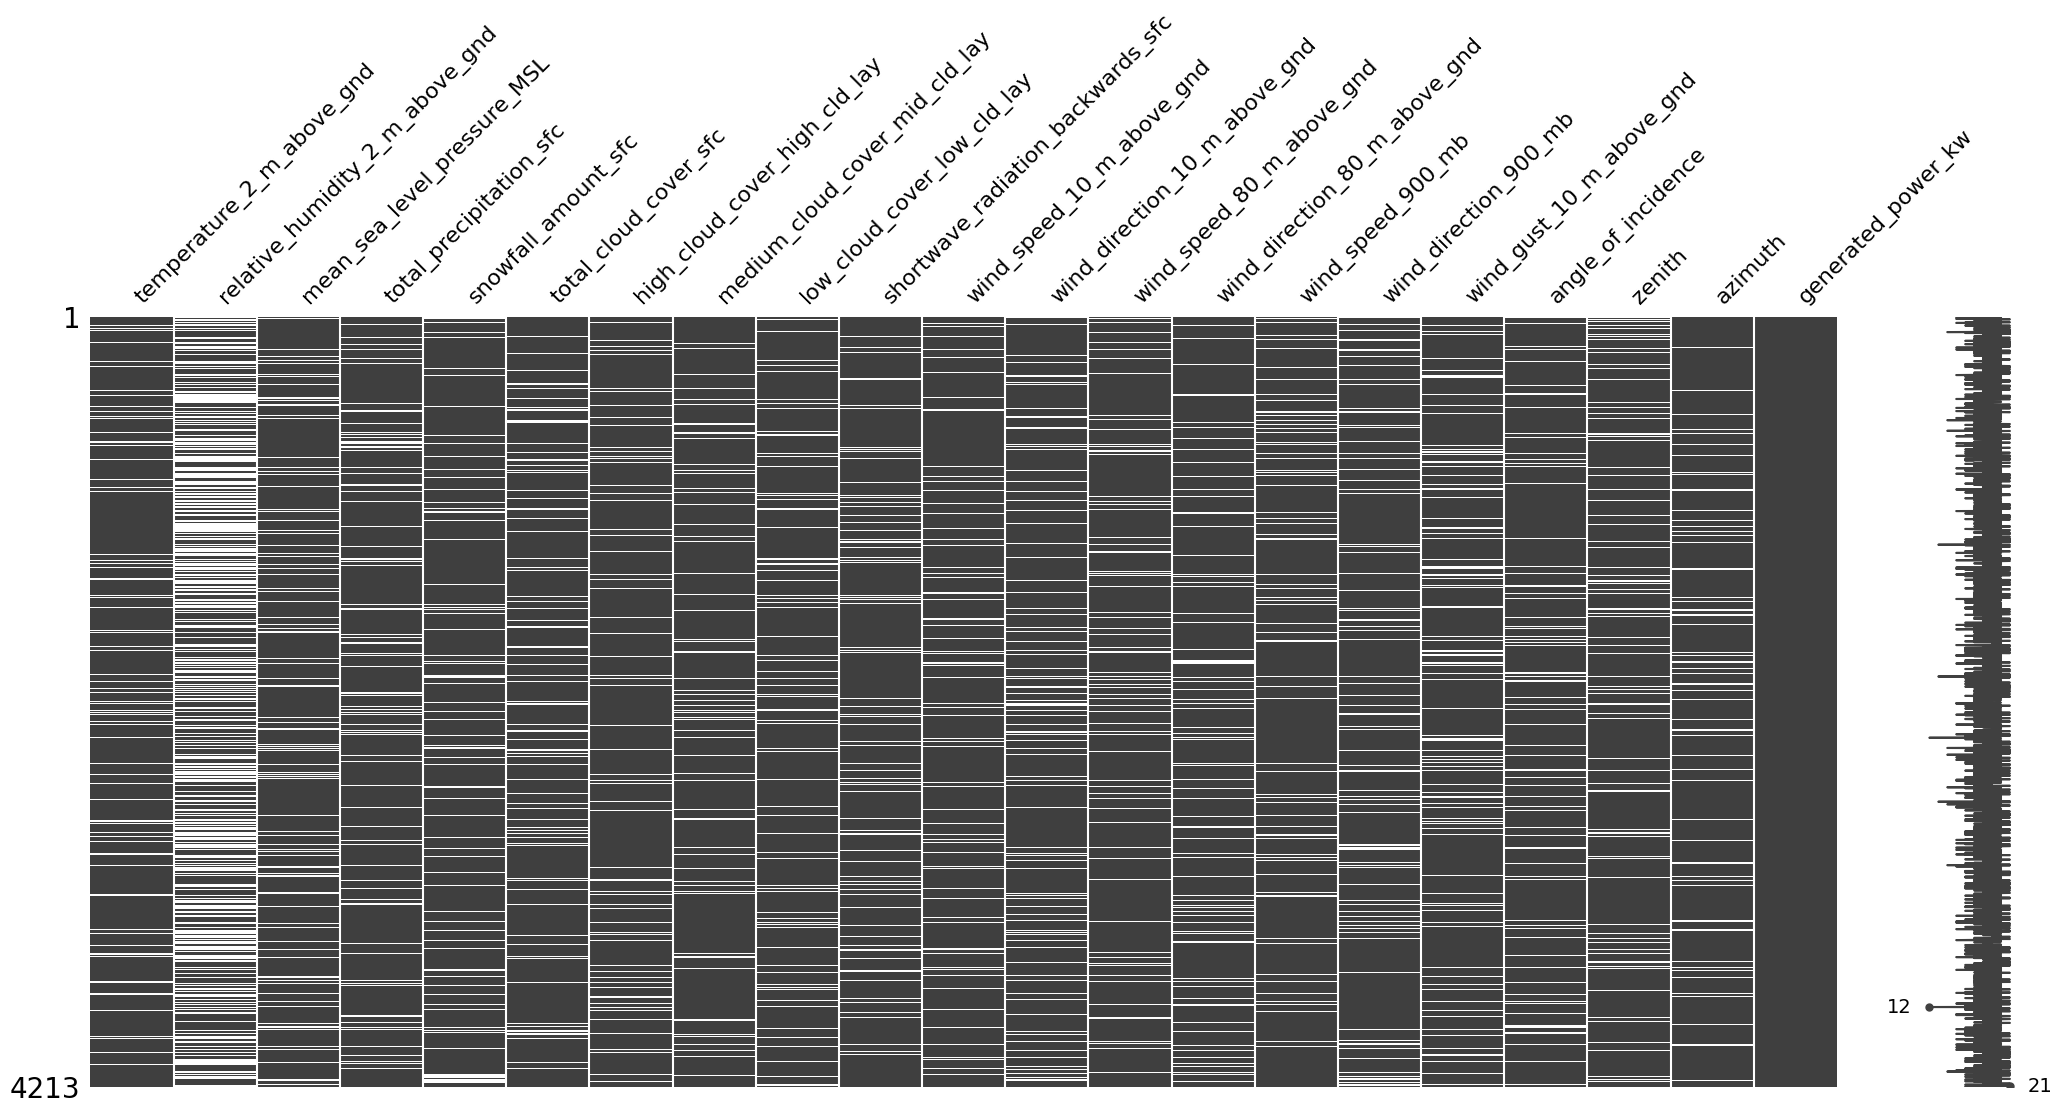

In [20]:
# Show graphycally the missing value
msno.matrix(df_missing)

In [21]:
# Find The number of values the missing values for each column
df_missing.isna().sum()

temperature_2_m_above_gnd             382
relative_humidity_2_m_above_gnd      1873
mean_sea_level_pressure_MSL           445
total_precipitation_sfc               453
snowfall_amount_sfc                   422
total_cloud_cover_sfc                 404
high_cloud_cover_high_cld_lay         447
medium_cloud_cover_mid_cld_lay        389
low_cloud_cover_low_cld_lay           457
shortwave_radiation_backwards_sfc     479
wind_speed_10_m_above_gnd             401
wind_direction_10_m_above_gnd         444
wind_speed_80_m_above_gnd             413
wind_direction_80_m_above_gnd         404
wind_speed_900_mb                     412
wind_direction_900_mb                 437
wind_gust_10_m_above_gnd              427
angle_of_incidence                    413
zenith                                420
azimuth                               389
generated_power_kw                      0
dtype: int64

In [22]:
# Find the percentage of missing values column by column
df_missing.isnull().sum(axis=0)/df_missing.shape[0]

temperature_2_m_above_gnd            0.090672
relative_humidity_2_m_above_gnd      0.444576
mean_sea_level_pressure_MSL          0.105625
total_precipitation_sfc              0.107524
snowfall_amount_sfc                  0.100166
total_cloud_cover_sfc                0.095894
high_cloud_cover_high_cld_lay        0.106100
medium_cloud_cover_mid_cld_lay       0.092333
low_cloud_cover_low_cld_lay          0.108474
shortwave_radiation_backwards_sfc    0.113696
wind_speed_10_m_above_gnd            0.095182
wind_direction_10_m_above_gnd        0.105388
wind_speed_80_m_above_gnd            0.098030
wind_direction_80_m_above_gnd        0.095894
wind_speed_900_mb                    0.097793
wind_direction_900_mb                0.103727
wind_gust_10_m_above_gnd             0.101353
angle_of_incidence                   0.098030
zenith                               0.099691
azimuth                              0.092333
generated_power_kw                   0.000000
dtype: float64

Depending on our analysis or model requirements, we might need to:

- Remove columns or row values contained missing data.

- Imputing missing values, that means substituting the missing values with the mean of the column (mean imputer), the median (median imputer) and other similar imputation.

### Handling numerical data

Since we tried to reproduce as natural as possible missing data through statistical methods, we observe a relatively low number of missing values in all columns which vary from 9% to 10,8%.

We try to minimize low-informative columns to our goal (energy output).

- The relative_humidity_2_m_above_gnd column have a high percentage of missing values(44%). That is most likely because of the correlation of missing values of temperature, artificially introduced before, which explains the discrepancy related to the other values. That can be changed, but let's keep it like that as humidity does not play a major role in power generation. Therefore, we decide to delete this column.

- Since we hardly find solar systems mounted above 30m above ground, we simply exclude wind_speed_80_m_above_gnd  and wind_direction_80_m_above_gnd from our analysis.

- As pressure and wind are directly correlated, we choose to consider only wind speed and direction measured in mb (wind_speed_900_mb  and wind_direction_900_mb ), as it tends to be less prone error. By dropping the columns wind_speed_10_m_above_gnd  wind_direction_10_m_above_gnd, we avoid redundancy contribution in our data.

- As wind_gust_10_m_above_gnd influence mainly the mounting system (not the energy production) we also drop this column.

In [23]:
df_missing = df_missing.drop(['relative_humidity_2_m_above_gnd',
                              'wind_speed_80_m_above_gnd',
                              'wind_direction_80_m_above_gnd',
                              'wind_speed_10_m_above_gnd',
                              'wind_direction_10_m_above_gnd',
                              'wind_gust_10_m_above_gnd' 
                               
                    ], axis=1)
df_missing.shape

(4213, 15)

We saparate our label vector from the rest of the the feature matrix.

In [24]:
y = pd.qcut(df_missing['generated_power_kw'], q=3, labels=['low','mid','high'])
X = df_missing.drop('generated_power_kw', axis=1) 

Since we have only numerical values, we can proceed with the data transformation pipeline.

In [25]:
df_missing

,temperature_2_m_above_gnd,mean_sea_level_pressure_MSL,total_precipitation_sfc,snowfall_amount_sfc,total_cloud_cover_sfc,high_cloud_cover_high_cld_lay,medium_cloud_cover_mid_cld_lay,low_cloud_cover_low_cld_lay,shortwave_radiation_backwards_sfc,wind_speed_900_mb,wind_direction_900_mb,angle_of_incidence,zenith,azimuth,generated_power_kw
0,2.17,1035.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,6.62,337.62,58.753108,83.237322,128.33543,454.100950
1,2.31,1035.1,0.0,0.0,0.0,NaN,0.0,0.0,NaN,4.61,321.34,NaN,75.143041,139.65530,1411.999400
2,3.65,1035.4,0.0,NaN,0.0,0.0,0.0,0.0,108.58,3.76,NaN,NaN,NaN,152.53769,2214.849300
3,5.82,1035.4,0.0,0.0,0.0,0.0,0.0,NaN,258.10,NaN,339.44,22.699288,64.883536,166.90159,2527.609200
4,7.73,1034.4,0.0,0.0,0.0,0.0,0.0,0.0,375.58,6.62,22.38,19.199908,NaN,182.13526,2640.203400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4208,8.69,1025.1,0.0,0.0,100.0,100.0,100.0,100.0,257.21,24.01,282.99,22.700907,64.952098,167.06794,173.410560
4209,NaN,1026.1,NaN,0.0,100.0,79.0,100.0,100.0,210.04,11.61,7.13,19.307487,63.895118,NaN,403.792220
4210,7.27,1026.3,0.1,0.0,100.0,73.0,100.0,100.0,113.92,7.95,354.81,25.249506,65.827032,197.33868,158.367780
4211,8.25,1025.5,0.0,0.0,100.0,74.0,66.0,100.0,186.90,5.94,14.04,36.361161,70.496313,NaN,126.953060


## Data Transformation pipeline

Pipeline 1: Ordinal categorical 

Features: total_cloud_cover_sfc, high_cloud_cover_high_cld_lay, medium_cloud_cover_mid_cld_lay, low_cloud_cover_low_cld_lay

 SimpleImputer(strategy="most_frequent") — fill missing cloud‐cover octas with the mode

OrdinalEncoder() — preserves the 0→8 ordering of “octas”

 MinMaxScaler() — puts all cloud‐cover variables on [0, 1] so they’re commensurate

Why? In many meteorological datasets cloud cover is recorded in discrete “octas” (0–8), so although numeric it really is an ordered category.

Pipeline 2: Numerical, roughly Gaussian

Features: temperature_2_m_above_gnd, mean_sea_level_pressure_MSL

SimpleImputer(strategy="mean") — temperature and MSL pressure tend to cluster around a central value

StandardScaler() — centers to zero and rescales so these roughly normal features play nicely with distance‑based learners

Why? Both surface temperature and sea‑level pressure typically have bell‑shaped distributions with relatively few extreme outliers.

 Pipeline 3: Numerical, skewed (no huge outliers)

Features: shortwave_radiation_backwards_sfc, angle_of_incidence, zenith, azimuth, wind_speed_900_mb, wind_direction_900_mb, 

 SimpleImputer(strategy="median") — more robust against the long right tail of radiation and wind speeds

MinMaxScaler() — compresses skewed ranges into [0, 1] without assuming symmetry

Why? All of these are continuous‑valued, strictly non‑negative (or bounded angles), often piling up at low values but without the truly extreme “rare event” spikes you get in precipitation.

Pipeline 4: Numerical with extreme outliers

Features: total_precipitation_sfc, snowfall_amount_sfc 

SimpleImputer(strategy="median") — median is stable when “zero” is by far the most common

KBinsDiscretizer(strategy="quantile") — buckets so that your model can learn different regimes (light drizzle vs. torrential rain) rather than being swamped by a handful of 50 mm/day outliers

MinMaxScaler() — finally rescales the binned output into [0, 1]

Why? Precipitation and snowfall are almost always zero, with infrequent but very large values—exactly the pattern that KBinsDiscretizer+quantile handles best.

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, FunctionTransformer 
import numpy as np


# 1. Ordinal categorical: cloud-cover octas (0–8)
ordinal_features = [
    "total_cloud_cover_sfc",
    "high_cloud_cover_high_cld_lay",
    "medium_cloud_cover_mid_cld_lay",
    "low_cloud_cover_low_cld_lay",
]

pipeline1 = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("to_octa", MinMaxScaler(feature_range=(0, 8))),               # <‑‑ rescales 
    ("ord_enc", "passthrough"),                # already integers 0‑8
])

# 2. Numerical, roughly Gaussian
gaussian_features = [
    "temperature_2_m_above_gnd",
    "mean_sea_level_pressure_MSL",
]
pipeline2 = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),  # center around climatological mean
    ("std", StandardScaler()),                     # standardize bell-shaped distributions
])

# 3. Numerical, skewed (long tail but no extreme outliers)
skewed_features = [
    "shortwave_radiation_backwards_sfc",
    "angle_of_incidence",
    "zenith",
    "azimuth",
    "wind_speed_900_mb",
    "wind_direction_900_mb",
]
pipeline3 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # robust to skew
    ("minmax", MinMaxScaler()),                     # compress skew into [0,1]
])

# 4. Numerical with extreme outliers
outlier_features = [
    "total_precipitation_sfc",
    "snowfall_amount_sfc",
]
pipeline4 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),        # median handles mass zeros
    ("minmax", MinMaxScaler()),                           # final scaling of binned output
])

Put everything together by building the ColumnTransformer:

In [27]:
# Import ColumnTransformer from sklearn.compose
from sklearn.compose import ColumnTransformer


# Combine all pipelines into a single ColumnTransformer with correct parameters
final_transformation = ColumnTransformer([
    ("cloud_octal", pipeline1, ordinal_features),
    ("gaussian", pipeline2, gaussian_features),
    ("skewed", pipeline3, skewed_features),
    ("outlier", pipeline4, outlier_features),
], 
remainder="drop",
verbose_feature_names_out=False,
sparse_threshold=0)


# Apply the transformation
pass_through_transformer = final_transformation.fit_transform(df_missing)

# Print the shape of the transformed data
print(f"Transformed data shape: {pass_through_transformer.shape}")

Transformed data shape: (4213, 14)


# Model Selection

We treat the problem as a supervised regression (features → target power), along with Tree-Based Ensemble Models because of the mixed-feature types. Although more advanced models would be fit to this problem, they are not considered for simplicity.

Linear models: 

- Ordinary Least Squares, Ridge, Lasso: fast, interpretable, great as a sanity check.

- Support Vector Regression (SVR): Kernelized, can capture non‑linearities, but doesn’t scale super‑well to huge datasets.

- k‑Nearest Neighbors (kNN) regression: Simple, non‑parametric; performance often limited in high‑dimensional feature spaces.

- Gaussian Process Regression: Provides uncertainty estimates, but scales cubically with sample size.

Tree-Based Ensemble Models

- Random Forest

- Gradient Boosting Machines

         - XGBoost, LightGBM, CatBoost: Excellent accuracy out of the box, handles missing data and categorical variables (CatBoost) with little fuss.

We perform the train and test split on our data.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape
print('Shape of X_train: {}\nShape of X_test: {}'.format(X_train.shape, X_test.shape))

Shape of X_train: (3370, 14)
Shape of X_test: (843, 14)


We search for the optimal model through nested cross validation. First we define the structure of our model and all possible variants we are interested in.

### IMBPipeline

In [29]:

model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('sampler', None),
    ('dim_reduction', None),
    ('classifier', None)
])

In [30]:
model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('cloud_octal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('to_octa',
                                                                   MinMaxScaler(feature_range=(0,
                                                                                               8))),
                                                                  ('ord_enc',
                                                                   'passthrough')]),
                                                  ['total_cloud_cover_sfc',
                                                   'high_cloud_cover_high_cld_lay',
                                                   'medium_cloud_cover_mid_cld_lay',
                                                   'low_cloud_cover_low_cld_la...
                                                  ['shortwave_radiation_backwards_sfc',
                                                   'angle_of_incidence',
                                                   'zenith', 'azimuth',
                                                   'wind_speed_900_mb',
                                                   'wind_direction_900_mb']),
                                                 ('outlier',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmax',
                                                                   MinMaxScaler())]),
                                                  ['total_precipitation_sfc',
                                                   'snowfall_amount_sfc'])],
                                   verbose_feature_names_out=False)),
                ('sampler', None), ('dim_reduction', None),
                ('classifier', None)])

### Sampler, Dimensionality Reduction, Classifier and Regressor configurations

In [31]:
transformer_configs = [
    {
        'trans': [final_transformation]
    }
]

sampler_configs = [
    {
        'sampler': [None]
    },
    {
        'sampler': [SMOTE()],
        'sampler__sampling_strategy': ['not majority', 'all']
    },
    {
        'sampler': [RandomOverSampler()],
        'sampler__sampling_strategy': ['not majority', 'all']
    }
]

dimensional_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.7, 0.8, 0.9, 0.95]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1_macro')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [7, 9, 11, 13] 
    }
]

classifier_configs = [
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [7, 11, 15, 19, 23]
    },
    {
        'classifier': [Perceptron()],
        'classifier__eta0': loguniform(0.001,10),
        'classifier__max_iter': [50,100,500,1000],
        'classifier__class_weight': [None, 'balanced']
    },
    {
        'classifier': [LogisticRegression(solver='lbfgs', max_iter=1000)],
        'classifier__C': loguniform(0.001,100),
        'classifier__penalty': ['l2'],
        'classifier__class_weight': [None, 'balanced']
    }
]

### Nested Cross-Validation

In [32]:
import itertools as it

config_set = [
    dict(it.chain(*(e.items() for e in configuration)))
    for configuration in it.product(
        transformer_configs,
        sampler_configs,
        dimensional_reduction_configs,
        classifier_configs,
    )
]
print(f"All possible model configurations: {len(config_set)}")

All possible model configurations: 36


Now we define the inner loop, for the hyperparameter optimizations, using RandomizedSearchCV.

In [33]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

best_models_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=config_set,
    n_iter=len(config_set),            # evaluate each config once
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="f1_macro",
    n_jobs=-1,
    random_state=42,
    verbose=2,
    error_score="raise")

Then we define the outer loop, to find the best model with the best set of hyperparameters, using cross_validate method to evaluate the performance of the model.

In [34]:
from sklearn.model_selection import cross_val_score

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

nested_scores = cross_val_score(
    best_models_search,
    X_train,   # or X if you prefer to split afterwards
    y_train,
    cv=outer_cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=3,
)

print(f"Nested CV macro‑F1: {nested_scores.mean():.4f} ± {nested_scores.std():.4f}")

                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('to_octa',
                                                  MinMaxScaler(feature_range=(0,
                                                                              8))),
                                                 ('ord_enc', 'passthrough')]),
                                 ['total_cloud_cover_sfc',
                                  'high_cloud_cover_high_cld_lay',
                                  'medium_cloud_cover_mid_cld_lay',
                                  'low_cloud_cover_low_cld_lay']),
                                ('gaussian',
                                 Pipeline...
                                                  SimpleImputer(strategy='median')),
                                                 ('minmax', MinMaxScaler())]),
                                 ['shortwave_radiation_backwards_sfc',
                 

In [35]:
best_models_search.fit(X_train, y_train)
best_model = best_models_search.best_estimator_
print("Selected pipeline:\n", best_model)

                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('to_octa',
                                                  MinMaxScaler(feature_range=(0,
                                                                              8))),
                                                 ('ord_enc', 'passthrough')]),
                                 ['total_cloud_cover_sfc',
                                  'high_cloud_cover_high_cld_lay',
                                  'medium_cloud_cover_mid_cld_lay',
                                  'low_cloud_cover_low_cld_lay']),
                                ('gaussian',
                                 Pipeline...
                                                  SimpleImputer(strategy='median')),
                                                 ('minmax', MinMaxScaler())]),
                           

In [36]:
scores = cross_validate(best_models_search, X_train, y_train, scoring='f1_macro', cv = 5, return_estimator=True, verbose=3, error_score='raise' )

                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('to_octa',
                                                  MinMaxScaler(feature_range=(0,
                                                                              8))),
                                                 ('ord_enc', 'passthrough')]),
                                 ['total_cloud_cover_sfc',
                                  'high_cloud_cover_high_cld_lay',
                                  'medium_cloud_cover_mid_cld_lay',
                                  'low_cloud_cover_low_cld_lay']),
                                ('gaussian',
                                 Pipeline...
                                                  SimpleImputer(strategy='median')),
                                                 ('minmax', MinMaxScaler())]),
                           

In [37]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

RandomOverSampler(sampling_strategy='all')
SequentialFeatureSelector(cv=None, estimator=Perceptron(), k_features=(13, 13),
                          scoring='f1_macro')
LogisticRegression(C=0.9761125443110441, class_weight='balanced', max_iter=1000) {'C': 0.9761125443110441, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.7093095216732438
----------
RandomOverSampler(sampling_strategy='all')
SequentialFeatureSelector(cv=None, estimator=Perceptron(), k_features=(13, 13),
                          scoring='f1_macro')
LogisticRegression(C=0.9761125443110441, class_weight='balanced', max_iter=1000) {'C': 0.9761125443110441, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class'

In [38]:
import warnings

warnings.filterwarnings(
    "ignore",                       # action
    message="Bins whose width are too small",  # regex on the warning text
    category=UserWarning,           # optional but makes the filter faster
     
)

for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train) \
                                    .predict(X_train)
    pred_test  = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train, average='macro')
    f1_test  = f1_score(y_test,  pred_test,  average='macro')
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.7142201541604511, F1 on test set:0.7023389399872793
F1 on training set:0.7142151046049143, F1 on test set:0.7010086971456594
F1 on training set:0.7159587214537506, F1 on test set:0.7179657816303778
F1 on training set:0.7159587214537506, F1 on test set:0.7179657816303778
F1 on training set:0.7159587214537506, F1 on test set:0.7179657816303778


We can search for the best model and the hyperparameters it used.

## Refining our Best Model

In [39]:
best_model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('dim_reducection', SFS(estimator=Perceptron(), cv = None, scoring = 'f1_macro')),
    ('classifier',LogisticRegression(solver='lbfgs', penalty = 'l2'))
])

In [40]:
params = {
    'classifier__C': uniform(loc = 5, scale = 10)
}

In [41]:
rs_best_model = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = params,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1),
    n_iter=20,
    scoring='f1_macro'
)

In [42]:
rs_best_model.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(sparse_threshold=0,
                                                                transformers=[('cloud_octal',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('to_octa',
                                                                                                MinMaxScaler(feature_range=(0,
                                                                                                                            8))),
                                                                                               ('ord_enc',
                                                                                                'passthrough')]),
                                                                               ['total_cloud_cover...
                                                                               ['total_precipitation_sfc',
                                                                                'snowfall_amount_sfc'])],
                                                                verbose_feature_names_out=False)),
                                             ('dim_reducection',
                                              SequentialFeatureSelector(cv=None,
                                                                        estimator=Perceptron(),
                                                                        scoring='f1_macro')),
                                             ('classifier',
                                              LogisticRegression())]),
                   n_iter=20,
                   param_distributions={'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fde9311b2b0>},
                   scoring='f1_macro')

TASK: Compute the F1-score on the test set

In [43]:
rs_best_model.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('cloud_octal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('to_octa',
                                                                   MinMaxScaler(feature_range=(0,
                                                                                               8))),
                                                                  ('ord_enc',
                                                                   'passthrough')]),
                                                  ['total_cloud_cover_sfc',
                                                   'high_cloud_cover_high_cld_lay',
                                                   'medium_cloud_cover_mid_cld_lay',
                                                   'low_cloud_cover_low_cld_la...
                                                 ('outlier',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmax',
                                                                   MinMaxScaler())]),
                                                  ['total_precipitation_sfc',
                                                   'snowfall_amount_sfc'])],
                                   verbose_feature_names_out=False)),
                ('dim_reducection',
                 SequentialFeatureSelector(cv=None, estimator=Perceptron(),
                                           k_features=(1, 1),
                                           scoring='f1_macro')),
                ('classifier', LogisticRegression(C=14.489108433782782))])

In [44]:
best_model = rs_best_model.best_estimator_
f1_score(y_test, rs_best_model.best_estimator_.predict(X_test), average='macro')

0.4431071916871288

Now, we can visualize the learning curve and the validation curve to quantify the bias/variance trade-off as a function of the size of the training set and the variation of the hyperparameter CC, for the case of Logistic Regression.

TASK: Visualize the learning and the validation curves.

In [45]:
cls = rs_best_model.best_estimator_

In [46]:
from sklearn.model_selection import learning_curve   # NEW

train_sizes, train_scores, test_scores = learning_curve(
    cls,                      # your fitted LogisticRegression estimator
    X=X_train,
    y=y_train,
    train_sizes=[0.1,  0.4, 0.5, 0.6, 0.7, 0.8,  1.0],
    cv=5,
    n_jobs=-1,
    scoring='f1_macro',       # macro = consistent with earlier f1_score
    shuffle=False
)

(7,) (7,) (7,)


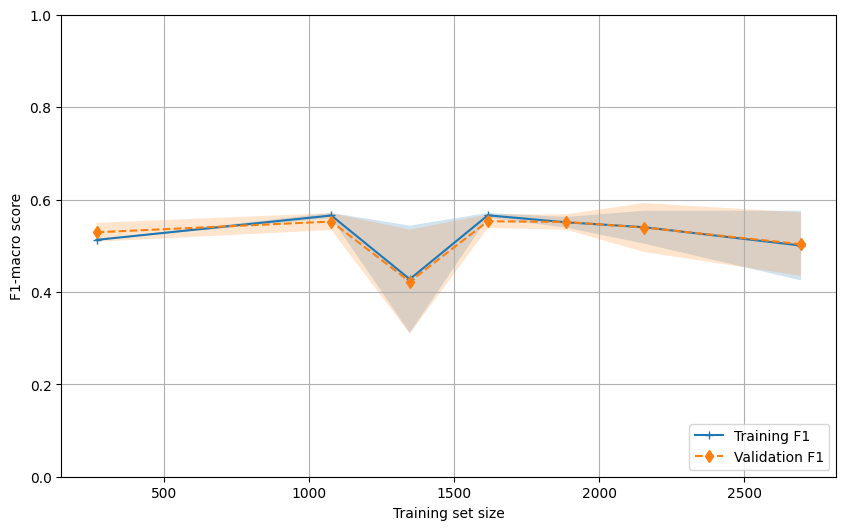

In [47]:
import numpy as np

# 1) Re‑compute the statistics from the *new* learning‐curve output:
train_mean = np.mean(train_scores, axis=1)   
train_std  = np.std( train_scores, axis=1)
test_mean  = np.mean(test_scores,  axis=1)
test_std   = np.std( test_scores,  axis=1)

# 2) (optional) sanity‑check the shapes:
print(train_sizes.shape, train_mean.shape, test_mean.shape)
# should all be (10,)

# 3) Now plot:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,6))
ax.plot( train_sizes, train_mean,    marker='+', label='Training F1')
ax.fill_between(train_sizes,
                train_mean-train_std,
                train_mean+train_std,
                alpha=0.2)
ax.plot( train_sizes, test_mean,     marker='d', linestyle='--', label='Validation F1')
ax.fill_between(train_sizes,
                test_mean-test_std,
                test_mean+test_std,
                alpha=0.2)

ax.set_xlabel('Training set size')
ax.set_ylabel('F1‑macro score')
ax.set_ylim(0.0, 1.0)
ax.grid(True)
ax.legend(loc='lower right')
plt.show()

Small gap between training and validationAt every training‑set size your blue (train) and orange (val) curves sit almost on top of one another. That means low variance—your model isn’t wildly over‑fitting the training folds.

Both scores are low and plateauing. Even on the full ~2,800‑sample training set, your F1‑macro stalls around 0.52–0.55. That flat “asymptote” tells you you’ve hit the ceiling of what this model (and these features) can learn: it’s under‑fitting (high bias).

What to do next: 

- Increase model capacity. 

- Loosen regularization (for logistic regression, bump up C).

- Try a more expressive algorithm (e.g. Random Forest, Gradient Boosting, a small neural net).

- Feature engineering: create interaction or polynomial terms. Add domain‑specific signals, embeddings, or richer metadata. Advanced preprocessingNonlinear transforms (e.g. splines, kernel featurizers).

In [48]:
from sklearn.model_selection import validation_curve  

range_C = [0.001,0.01,0.1,1,10,100, 1000]
train_scores, test_scores = validation_curve(cls,
        X=X_train, 
        y=y_train, 
        param_range=
        range_C, 
        param_name='classifier__C',
        cv=10, 
        n_jobs=-1, 
        scoring='f1_macro'
)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
     


In [49]:
print("C values:", range_C)
print("Train means:", train_mean)
print("Test means: ", test_mean)

C values: [0.001, 0.01, 0.1, 1, 10, 100, 1000]
Train means: [0.40231573 0.44569772 0.48787151 0.49199074 0.49198773 0.49203957
 0.4920435 ]
Test means:  [0.40793254 0.45290845 0.49427526 0.4984982  0.50022262 0.50022262
 0.50022262]


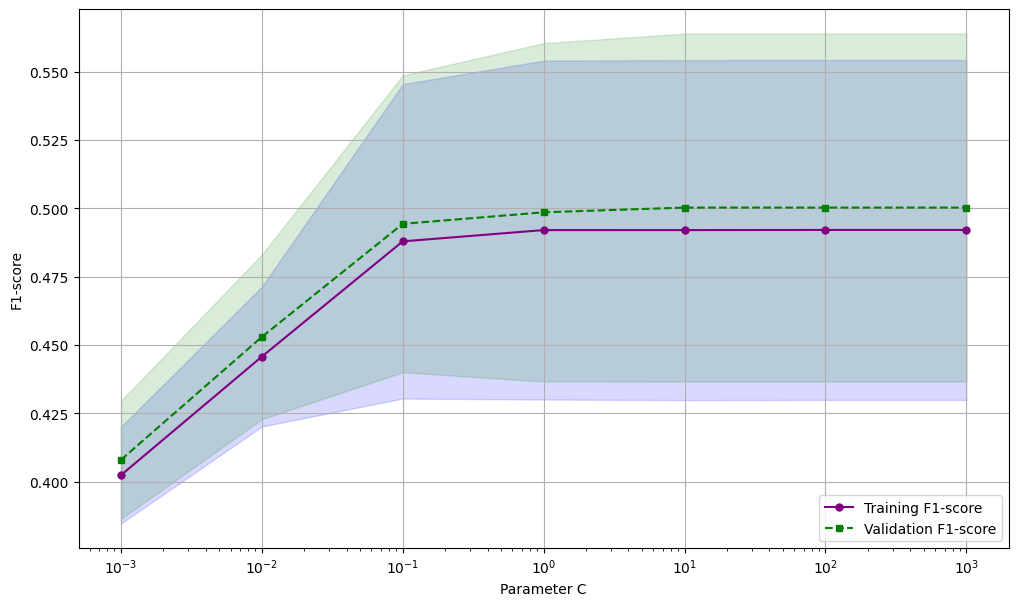

In [50]:
fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_C, train_mean,
         color='purple', marker='o',
         markersize=5, label='Training F1-score')

ax.fill_between(range_C,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_C, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation F1-score')

ax.fill_between(range_C,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter C')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_xscale('log')

- The model is under‑fitting for small C.

- Optimal C is in the 0.1–10 range, where you maximize F1 on held‑out folds.

- No sign of explosion in variance at large C, so we could safely pick a C in that plateau (say C=1) without worrying about over‑fit.

- Since even at its best the F1 only reaches ~0.56, further gains will likely require more expressive features or a richer model, not just tweaking C.

## Confusion Matrix

A confusion matrix is a table used to evaluate the performance of a model, by comparing the actual and predicted classes for a set of data.For binary classification problems, the confusion matrix has two rows and two columns:The rows correspond to the actual class labels.The columns correspond to the predicted class labels.We generate and plot the confusion matrix.[[TN FP] [FN TP]]

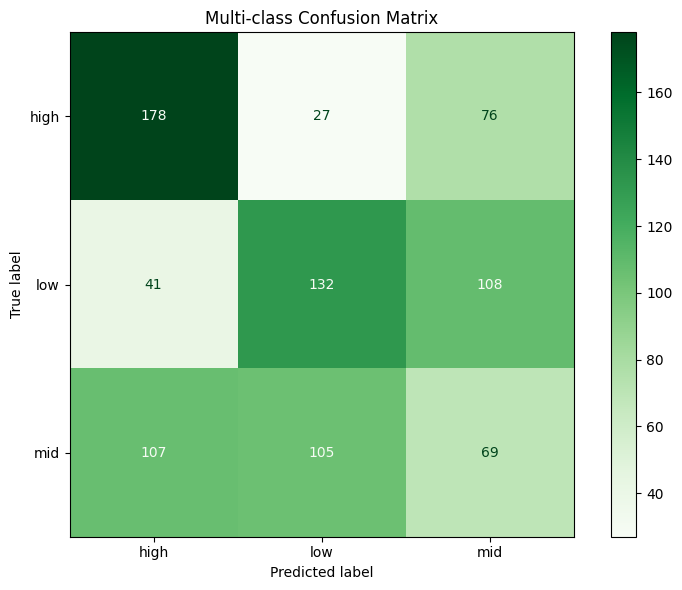

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# get your best estimator
cls = rs_best_model.best_estimator_  # Corrected variable name

# predict on the test set
y_pred = cls.predict(X_test)

# define your class labels in the same order you want them plotted
labels = ['high', 'low', 'mid']

# compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Greens', values_format='d', ax=ax)

ax.set_title('Multi-class Confusion Matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.tight_layout()
plt.show()

Balanced bins: used qcut(..., q=3), so each class has ~281 examples.

Recall by class

high: 178/281 ≈ 0.63

low: 134/281 ≈ 0.48

mid:  67/281 ≈ 0.24

⇒ You recover “high” best, “mid” worst.

Precision by class:

“high” was predicted 178+42+107 = 327 times ⇒ 178/327 ≈ 0.54

“low” predicted 28+134+107 = 269 times ⇒ 134/269 ≈ 0.50

“mid” predicted 75+105+ 67 = 247 times ⇒  67/247 ≈ 0.27

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0ed69efa-1cff-4e1b-967d-f67d3cac50cf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>